## Import des libraries

In [1]:
from pandas import DataFrame
from pandas import read_csv
from pandas import crosstab
import bigml.api
from bigml.api import BigML
import kaggle
import matplotlib


## Modification des features de cs-train

In [ ]:
df = read_csv('cs-training.csv', header=0, index_col=0)
df.fillna(0, inplace=True)
df['NumberOfTimeTotalDelay'] = df['NumberOfTime30-59DaysPastDueNotWorse']
                                + df['NumberOfTimes90DaysLate']
                                + df['NumberOfTime60-89DaysPastDueNotWorse']
df['isOld'] =df['age']>70
df.to_csv('train_full.csv')

## Modification des features de cs_test

In [ ]:
df = read_csv('cs-test.csv', header=0, index_col=0)
df.fillna(0, inplace=True)
df['NumberOfTimeTotalDelay'] = df['NumberOfTime30-59DaysPastDueNotWorse']
                                + df['NumberOfTimes90DaysLate']
                                + df['NumberOfTime60-89DaysPastDueNotWorse']
df['isOld'] =df['age']>70
df.to_csv('test_full.csv')

## Identification du projet sur BigML

In [3]:
api = BigML(project='project/5d94a344eba31d460c000235')

## Création des datasets avec les cs-train et cs-test modifiés

In [ ]:
source_train = api.create_source('train_full.csv')
origin_dataset = api.create_dataset(source_train)
source_test = api.create_source('test_full.csv')
test_dataset = api.create_dataset(source_test)

## Split du train dataset

In [ ]:
train_dataset = api.create_dataset(
    origin_dataset, {"name": "Training_split_Jupyter",
                     "sample_rate": 0.8, "seed": "my seed"})
val_dataset = api.create_dataset(
    origin_dataset, {"name": "Validation_split_Jupyter",
                     "sample_rate": 0.8, "seed": "my seed",
                     "out_of_bag": True})

## Création du modèle avec le split de train dataset

In [ ]:
ensemble = api.create_ensemble(train_dataset,{"name": "ensemble_Jupyter",
     "objective_field": "SeriousDlqin2yrs"})

## Evaluation du modèle avec val dataset

In [ ]:
evaluation = api.create_evaluation(ensemble, val_dataset)

## Création du Batch Prediction, avec le test set modifié

In [ ]:
batch_prediction = api.create_batch_prediction(ensemble, test_dataset, {
    "name": "ensemble_prediction_Jupyter", "all_fields": True,
    "header": True,
    "confidence": True,
    "probabilities": True})
api.ok(batch_prediction)

## Export du batch prediction en csv

In [ ]:
api.download_batch_prediction(batch_prediction,
    filename='ensemble_prediction_Jupyter.csv')

## Modification du fichier csv à envoyer à Kaggle

In [ ]:
df = read_csv('ensemble_prediction_Jupyter.csv', header=0, index_col=0)
df2 =df [['1 probability']]
df2.index.names = ['Id']
df2.rename(columns={"1 probability": "Probability"},inplace=True)

In [ ]:
df2.to_csv('prediction_kaggle.csv')

## Soumission à Kaggle

In [ ]:
submission_file = "prediction_kaggle.csv"
kaggle.api.competition_submit(submission_file, "BigML ensemble", "GiveMeSomeCredit")

## Afficher l'évaluation du modèle

In [ ]:
evaluation = api.get_evaluation('evaluation/5dacd5997811dd0137000513')
api.pprint(evaluation['object']['result'])

## Récupérer l'accuracy de l'évaluation

In [ ]:
api.pprint(evaluation['object']['result']['model']['accuracy'])

## Batch Prediction sur val dataset pour estimer les erreurs

In [ ]:
batch_prediction = api.create_batch_prediction('ensemble/5dacd57a7811dd7f2d003bf8', 'dataset/5dacd5617811dd7f2d003bf5', {
    "name": "ensemble_prediction_sur_validation", "all_fields": True,
    "header": True,
    "confidence": True,
    "probabilities": True})
api.ok(batch_prediction)

In [ ]:
api.download_batch_prediction('batchprediction/5db1c37ee47684746800980b',
    filename='ensemble_prediction_valset.csv')

In [ ]:
df = read_csv('ensemble_prediction_valset.csv', header=0, index_col=0)
df

In [ ]:
df.rename(columns={"SeriousDlqin2yrs.1" : "SeriousDlqin2yrs_predict"},inplace=True)
df

## Création fonction Matrice Confusion (sans seuil)

In [ ]:
def confusion(row):
    if (row['SeriousDlqin2yrs'] == 0 and row['SeriousDlqin2yrs_predict'] == 0):
        confusion_value = 'TN'
    if (row['SeriousDlqin2yrs'] == 0 and row['SeriousDlqin2yrs_predict'] == 1):
        confusion_value = 'FP'
    if (row['SeriousDlqin2yrs'] == 1 and row['SeriousDlqin2yrs_predict'] == 0):
        confusion_value = 'FN'
    if (row['SeriousDlqin2yrs'] == 1 and row['SeriousDlqin2yrs_predict'] == 1):
        confusion_value = 'TP'
    return confusion_value

df['confusion'] = df.apply(confusion, axis = 1)
df.to_csv('confusion_matrix.csv', index=False)

## Création fonction Matrice Confusion (avec seuil)

In [ ]:
def seuil(row):    
    seuil_value = 0.5
    if (row['1 probability'] < seuil_value):
        seuil_value = 0
    else:
        seuil_value = 1
    return seuil_value

def confusion_seuil(row):
    if (row['SeriousDlqin2yrs'] == 0 and row['my_predict'] == 0):
        confusion_value = 'TN'
    if (row['SeriousDlqin2yrs'] == 0 and row['my_predict'] == 1):
        confusion_value = 'FP'
    if (row['SeriousDlqin2yrs'] == 1 and row['my_predict'] == 0):
        confusion_value = 'FN'
    if (row['SeriousDlqin2yrs'] == 1 and row['my_predict'] == 1):
        confusion_value = 'TP'
    return confusion_value

df['my_predict'] = df.apply(seuil, axis = 1)
df['confusion'] = df.apply(confusion_seuil, axis = 1)
df.to_csv('confusion_matrix_avec seuil.csv', index=False)

In [ ]:
df = read_csv('confusion_matrix.csv', header=0, index_col=False)

## Compte le nombre d'erreurs (sans seuil)

In [ ]:
nb_erreur = list(df.confusion.values)
TP = nb_erreur.count("TP")
TN = nb_erreur.count("TN")
FP = nb_erreur.count("FP")
FN = nb_erreur.count("FN")

print(f"TP = {TP} \nTN = {TN} \nFP = {FP} \nFN = {FN}")


## Compte le nombre d'erreurs (avec seuil)

In [ ]:
df = read_csv('confusion_matrix_avec seuil.csv', header=0, index_col=False)
nb_erreur = list(df.confusion.values)
TP = nb_erreur.count("TP")
TN = nb_erreur.count("TN")
FP = nb_erreur.count("FP")
FN = nb_erreur.count("FN")

print(f"TP = {TP} \nTN = {TN} \nFP = {FP} \nFN = {FN}")

## Calcul du gain total

In [ ]:
#Actual / Predicted    0    1
#0    $500    -$500
#1    -$2500    $0

#Actual / Predicted 0 / 1
#0    TN    FP
#1    FN    TP

gain_total = TN * 500 + FP * -500 + FN * -2500 + TP * 0
print(f"Le gain total est: {gain_total}")

## Optimisation du seuil pour maximaliser le gain total

In [ ]:
def seuil_optimisation(row):
    seuil_value = seuil
    if (row['1 probability'] < seuil_value):
        seuil_value = 0
    else:
        seuil_value = 1
    return seuil_value

seuil = 0.5
df['my_predict'] = df.apply(seuil_optimisation, axis = 1)
df['confusion'] = df.apply(confusion, axis = 1)


In [ ]:
def confusion_seuil(row):
    if (row['SeriousDlqin2yrs'] == 0 and row['my_predict'] == 0):
        confusion_value = 'TN'
    if (row['SeriousDlqin2yrs'] == 0 and row['my_predict'] == 1):
        confusion_value = 'FP'
    if (row['SeriousDlqin2yrs'] == 1 and row['my_predict'] == 0):
        confusion_value = 'FN'
    if (row['SeriousDlqin2yrs'] == 1 and row['my_predict'] == 1):
        confusion_value = 'TP'
    return confusion_value

df = read_csv('ensemble_prediction_valset.csv', header=0, index_col=0)
seuil = 0.5

# initialisation gain_total_max avec seuil 0.5
df['my_predict'] = df.apply(seuil_optimisation, axis = 1)
df['confusion'] = df.apply(confusion_seuil, axis = 1)
nb_erreur = list(df.confusion.values)
TP = nb_erreur.count("TP")
TN = nb_erreur.count("TN")
FP = nb_erreur.count("FP")
FN = nb_erreur.count("FN")
gain_total_max = TN * 500 + FP * -500 + FN * -2500 + TP * 0
gain_total = 0
print(f"Gain total de référence: {gain_total}")
seuil = 0
seuil_pas = 0.01

# bouclage du seuil

while seuil < 1:
    seuil += seuil_pas
    df['my_predict'] = df.apply(seuil_optimisation, axis = 1)
    df['confusion'] = df.apply(confusion_seuil, axis = 1)
    
    nb_erreur = list(df.confusion.values)
    TP = nb_erreur.count("TP")
    TN = nb_erreur.count("TN")
    FP = nb_erreur.count("FP")
    FN = nb_erreur.count("FN")
    gain_total = TN * 500 + FP * -500 + FN * -2500 + TP * 0
    if gain_total > gain_total_max:
        gain_total_max = gain_total
        seuil_max = seuil - seuil_pas
    print(f"Seuil: {round(seuil-seuil_pas, 2)} Gain total: {gain_total}")
seuil -= seuil_pas
print(f"Le gain total max est {gain_total_max} pour un seuil de {round(seuil_max, 2)}")  

## Sauvegarde avec le meilleur seuil

In [ ]:
seuil = seuil_max
df = read_csv('ensemble_prediction_valset.csv', header=0, index_col=0)
df['my_predict'] = df.apply(seuil_optimisation, axis = 1)
df['confusion'] = df.apply(confusion_seuil, axis = 1)
nb_erreur = list(df.confusion.values)
TP = nb_erreur.count("TP")
TN = nb_erreur.count("TN")
FP = nb_erreur.count("FP")
FN = nb_erreur.count("FN")
gain_total = TN * 500 + FP * -500 + FN * -2500 + TP * 0
print(f"Le gain total max est {gain_total_max} pour un seuil de {round(seuil_max, 2)}")
df.to_csv('confusion_matrix_avec_meilleur_seuil.csv', index=True)

## Accuracy

In [ ]:
Accuracy = (TP + TN) / (TP + TN + FP + FN)
print(Accuracy)

## 100 premières erreurs

In [ ]:
df = read_csv('confusion_matrix_avec_meilleur_seuil.csv', header=0, index_col=False)
df.rename(columns={"field1" : "Id"},inplace=True)
df.to_csv('confusion_matrix_avec_meilleur_seuil.csv', index=True)

In [ ]:
df['error_abs'] = abs(seuil_max - df['1 probability'])
df_2 = df[df['confusion'].isin(["FN","FP"])]
df_2.sort_values(by=['error_abs'], ascending=False, inplace=True)
df_2.head(100)

In [ ]:
df_2.head(100).to_csv('100_grosses_erreurs.csv', index=False)

In [ ]:
df3 = read_csv('100_grosses_erreurs.csv')
df3

## Création et affichage de la courbe du gain en fonction de l'indice (Guillaume)

In [ ]:
def cost_threshold(threshold):
    prediction_threshold = prediction['1 probability'] > threshold

    #~ = "not" pour les tableaux / & = "and" pour les tableaux / | = "or" pour les tableaux

    P_pred = prediction_threshold
    N_pred = ~prediction_threshold

    P_real = (prediction['SeriousDlqin2yrs'] == 1)
    N_real = (prediction['SeriousDlqin2yrs'] == 0)

    TP = len(prediction.loc[P_pred & P_real])
    TN = len(prediction.loc[N_pred & N_real])
    FP = len(prediction.loc[P_pred & N_real])
    FN = len(prediction.loc[N_pred & P_real])

    TP_cost = 0
    FN_cost = -2500
    FP_cost = -500
    TN_cost = 500

    cost = TP * TP_cost
    cost += TN * TN_cost
    cost += FP * FP_cost
    cost += FN * FN_cost

    return cost

import matplotlib.pyplot as plt
%matplotlib inline
table = [cost_threshold(n/1000) for n in range(0,1000)]
plt.plot(table)


Test méthode Guillaume pour la courbe d'opitmisation du seuil

In [ ]:
df = read_csv('ensemble_prediction_valset.csv')

def cost_threshold(threshold):
    prediction_threshold = df['1 probability'] > threshold

    #~ = "not" pour les tableaux / & = "and" pour les tableaux / | = "or" pour les tableaux

    P_pred = prediction_threshold
    N_pred = ~prediction_threshold

    P_real = (df['SeriousDlqin2yrs'] == 1)
    N_real = (df['SeriousDlqin2yrs'] == 0)

    TP = len(df.loc[P_pred & P_real])
    TN = len(df.loc[N_pred & N_real])
    FP = len(df.loc[P_pred & N_real])
    FN = len(df.loc[N_pred & P_real])

    TP_cost = 0
    FN_cost = -2500
    FP_cost = -500
    TN_cost = 500

    cost = TP * TP_cost
    cost += TN * TN_cost
    cost += FP * FP_cost
    cost += FN * FN_cost

    return cost

import matplotlib.pyplot as plt
%matplotlib inline
table = [cost_threshold(n/1000) for n in range(0,1000)]
plt.plot(table)

# cherche le maximum de la courbe
max_gain = max(table)
max_threshold = table.index(max_gain)/1000
print(f"L'indice optimal est de {max_threshold} pour un gain de ${max_gain}")

#from scipy import polyfit
import numpy
import warnings
x = []
y = []
for xi in range(0, len(table)):
    y.append(table[xi])
    x.append(table.index(table[xi]))
   
coeff = polyfit(x, y, 2)
print(coeff)

plt.plot(x,y,"*")
plt.plot(x,coeff[0]*x**2+coeff[1]*x+coeff[2])
plt.show()

## Compte Erreurs (Bastien)

In [ ]:
df = read_csv('confusion_matrix.csv', header=0, index_col=False)
matrix =df.groupby(['confusion']).confusion.count()  # le deuxième Error est la répétition du nom de la colonne Error
print(matrix)
# df_matrix = DataFrame(data={'Predicted_1':[matrix.TP, matrix.FP], 'Predicted_0':[matrix.TN, matrix.FN]})
# df_matrix

## Matrice de confusion (Laurent)

In [ ]:
df = read_csv('confusion_matrix.csv', header=0, index_col=False)
df
confusion_matrix = df['confusion'].value_counts()
print(confusion_matrix)

# calcul de l'AUC 

In [ ]:
# grouper tous les positifs
# comparer chaque positif à tous les négatifs
# compter le nombre de fois où le 1_proba d'un positif est supérieur au 1_proba d'un négatif
# faire le ratio sur le nombre total de ocmbianaisons

df = read_csv('confusion_matrix.csv', header=0, index_col=False)
df
df_positives = df.loc[df['SeriousDlqin2yrs_predict'] == 1]
df_negatives = df.loc[df['SeriousDlqin2yrs_predict'] == 0]

In [6]:
df_positives.iloc[1]

NameError: name 'df_positives' is not defined

In [ ]:
for row_pos in range(len(df_positives)):
    for row_neg in range(len(df_negatives)):
        if df_positives.iloc['1 probability'][row_pos] > df_negatives.iloc['0 probability'][row_neg]:
            count_pos += 1
        
df_positives
df_negatives

## AUC Laurent

In [ ]:
df = read_csv('ensemble_prediction_valset.csv', header =0, index_col = False)
df

In [ ]:
# Tri des données pour préparer le calcul de AUC
df_sorted = df.sort_values('1 probability', ascending=False)

#  Calcul de la somme des négatifs en dessous de chaque positifs (1 probability est inférieur)

N_sum_below = 0
for index in range(len(df_sorted)):
    if df_sorted['SeriousDlqin2yrs'].iloc[index] == 1:
        N_sum_below += df_sorted['SeriousDlqin2yrs'][index+1:].value_counts().loc[0]

# Calcul du produit nombre N * nombre P
N_number = df_sorted['SeriousDlqin2yrs'].value_counts().loc[0]
P_number  = df_sorted['SeriousDlqin2yrs'].value_counts().loc[1]
NP_product = N_number * P_number

# Calcul auc
AUC = N_sum_below / NP_product
AUC


## AUC Maud

In [ ]:
df = read_csv('ensemble_prediction_valset.csv', header =0, index_col = False)
df

In [ ]:
positive = (df['SeriousDlqin2yrs'] == 1)
nb_positive=len(df.loc[positive])
nb_negative=len(df.loc[~positive])

result = df[['SeriousDlqin2yrs','1 probability']]
threshold_list = result.sort_values(by='1 probability',ascending=False)['SeriousDlqin2yrs'].values

auc = 0
P_cumul = 0

%%timeit
for i in range(len(threshold_list)):
    if threshold_list[i] == 1:
        P_cumul += 1
    else:
        auc += P_cumul
        
auc = auc/(nb_positive*nb_negative)

print(auc)

## AUC Louis

In [ ]:
mask_positives = (val_pred.SeriousDlqin2yrs==1)
mask_negatives = (val_pred.SeriousDlqin2yrs==0)
positives = val_pred[mask_positives]
negatives = val_pred[mask_negatives]

c = 0
n = positives.shape[0] * negatives.shape[0]
for proba_positive in positives['1 Proba']:
    count = negatives[ negatives['1 Proba'] < proba_positive ].shape[0]
    c = c+count

auc = c/n
print(auc)

## AUC Louis (à coder)
### Mesure indépendante du seuil choisi. Traduit la performance du modèle sans tenir compte du gain final. Traduit la capacité du modèle à distinguer les >0 et les <0

In [ ]:
c = 0
pos
neg
for p in pos:
    for n in neg:
        if p['1 proba'] > n['1 proba']:
            c += 1
N = pos.shape * neg.shape
AUC = C / N

## AUC Guillaume

In [ ]:
is_positive = (prediction['SeriousDlqin2yrs'] == 1)
df_threshold=DataFrame(index=prediction['1 probability'])
df_threshold['positive'] = is_positive.values
df_threshold.sort_index(inplace=True, ascending=False)

df_threshold['positive_sum'] =  df_threshold['positive'].cumsum()
auc=df_threshold.loc[~df_threshold['positive']]['positive_sum'].sum()/(nb_positive*nb_negative)

### Summary report

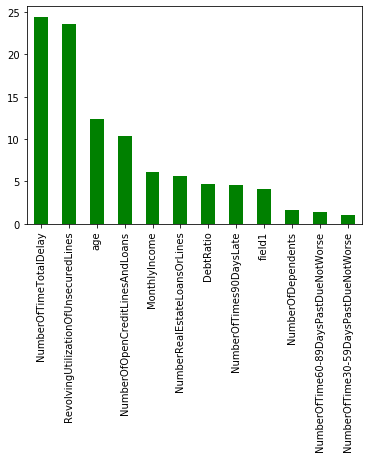

In [5]:
model = api.get_ensemble("ensemble/5dacd57a7811dd7f2d003bf8")
#importances = api.pprint(model['object']['importance'])
importances = model['object']['importance']
#importances['000000']

importances_named = dict()
for column, importance in importances.items():
    column_name = model['object']['ensemble']['fields'][column]['name']
    importances_named[column_name] = [importance * 100]
df = DataFrame.from_dict(importances_named, orient='index')
df
df = df.sort_values(0, ascending=False)
df.plot(kind='bar', color='green', legend=False);
#hist = df.hist()
#hist

In [ ]:
model = api.get_ensemble("ensemble/5dacd57a7811dd7f2d003bf8")
#importances = api.pprint(model['object']['importance'])
importances = model['object']['importance']
#importances['000000']

data = importances_named
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(figsize=(20, 5), sharey=True)
axs.bar(names, values)

xtick_labels = ['Id','RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome', 'MonthlyDebt', 'DisposableIncome', 'BalancedIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'WeightedOfLatePayment', 'NumberOfDependents', 'SeriousDlqin2yrs']
plt.xticks(names, xtick_labels, rotation=30)

fig.suptitle('Importance fields')

In [ ]:
importance = api.pprint(model['object'])
importance

## Courbe de performance
tracer courbe AUC = f(nbre data train) : itérer de 0 à 80% du dataset trainfull (0 à 100% du split)

### Bonus
mesurer la performance sur le train set

### Récupération AUC sur validation

In [ ]:
evaluation = api.get_evaluation('evaluation/5dacd5997811dd0137000513')
api.pprint(evaluation['object']['result']['model'])

In [ ]:

auc = evaluation['object']['result']['model']['per_class_statistics'][1]['area_under_roc_curve']
auc

# Courbe de Performance

### Création de 10 splits de 10% de train_set

In [ ]:
# sépratation en 80/20 du train_set
train_set_split_20 = api.create_dataset('dataset/5dacd5607811dd7f2d003bf2', {"name": "train_split_20",
                                                                                  "sample_rate": 0.2})
train_set_split_80 = api.create_dataset('dataset/5dacd5607811dd7f2d003bf2', {"name": "train_split_80",
                                                                                  "sample_rate": 0.2,
                                                                                    "out_of_bag":True})

# séparation de la fraction 20 en 2 50/50 ->  2 fractions de 10%
train_set_split_1 = api.create_dataset(train_set_split_20, {"name": "train_split_1",
                                                           "sample_rate": 0.5})
train_set_split_2 = api.create_dataset(train_set_split_20, {"name": "train_split_2",
                                                           "sample_rate": 0.5,
                                                           "out_of_bag": True})


# séparation de la fraction 80 en 2 * 40%
train_set_split_40_1 = api.create_dataset(train_set_split_80, {"name": "train_split_40_1",
                                                           "sample_rate": 0.5})
train_set_split_40_2 = api.create_dataset(train_set_split_80, {"name": "train_split_40_2",
                                                           "sample_rate": 0.5,
                                                           "out_of_bag": True})

# séparation des fractions 40% en 2 * 20% chacune
train_set_split_20_1 = api.create_dataset(train_set_split_40_1, {"name": "train_split_20_1",
                                                           "sample_rate": 0.5})
train_set_split_20_2 = api.create_dataset(train_set_split_40_1, {"name": "train_split_20_2",
                                                           "sample_rate": 0.5,
                                                           "out_of_bag": True})

train_set_split_20_3 = api.create_dataset(train_set_split_40_2, {"name": "train_split_20_3",
                                                           "sample_rate": 0.5})
train_set_split_20_4 = api.create_dataset(train_set_split_40_2, {"name": "train_split_20_4",
                                                           "sample_rate": 0.5,
                                                           "out_of_bag": True})

# séparation de chaque fraction de 20% en 2 fractions de 10% -> 8 fractions de 10%
train_set_split_3 = api.create_dataset(train_set_split_20_1, {"name": "train_split_3",
                                                           "sample_rate": 0.5})
train_set_split_4 = api.create_dataset(train_set_split_20_1, {"name": "train_split_4",
                                                           "sample_rate": 0.5,
                                                           "out_of_bag": True})

train_set_split_5 = api.create_dataset(train_set_split_20_2, {"name": "train_split_5",
                                                           "sample_rate": 0.5})
train_set_split_6 = api.create_dataset(train_set_split_20_2, {"name": "train_split_6",
                                                           "sample_rate": 0.5,
                                                           "out_of_bag": True})

train_set_split_7 = api.create_dataset(train_set_split_20_3, {"name": "train_split_7",
                                                           "sample_rate": 0.5})
train_set_split_8 = api.create_dataset(train_set_split_20_3, {"name": "train_split_8",
                                                           "sample_rate": 0.5,
                                                           "out_of_bag": True})

train_set_split_9 = api.create_dataset(train_set_split_20_4, {"name": "train_split_9",
                                                           "sample_rate": 0.5})
train_set_split_10 = api.create_dataset(train_set_split_20_4, {"name": "train_split_10",
                                                           "sample_rate": 0.5,
                                                           "out_of_bag": True})


In [198]:
# Récupération des datasets
split_list = [
    train_set_split_1,
    train_set_split_2,
    train_set_split_3,
    train_set_split_4,
    train_set_split_5,
    train_set_split_6,
    train_set_split_7,
    train_set_split_8,
    train_set_split_9,
    train_set_split_10
]

   

### Modèle ensemble

In [ ]:
dataset = []
ensemble = []

# Création des 10 modèles
for split in range(len(split_list)):
    dataset.append(split_list[split]) # possibilité d'append directement les splits sans passer par dataset
    ensemble.append(api.create_ensemble(dataset,{"name": "ensemble_"+(str(split+1)),
     "objective_field": "SeriousDlqin2yrs"}))
    api.ok(ensemble[split])

In [199]:
# Evaluation des modèles sur le validation_set
evaluation = []

for model_number in range(len(ensemble)):
    evaluation.append(api.create_evaluation(ensemble[model_number], 'dataset/5dacd5617811dd7f2d003bf5'))
    api.ok(evaluation[model_number])


In [200]:
# Récupération des AUC
auc = []
for eval_number in range(len(evaluation)):
    auc.append(evaluation[eval_number]['object']['result']['model']['per_class_statistics'][1]['area_under_roc_curve'])

In [ ]:
train_percent = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
performance_ensemble = auc


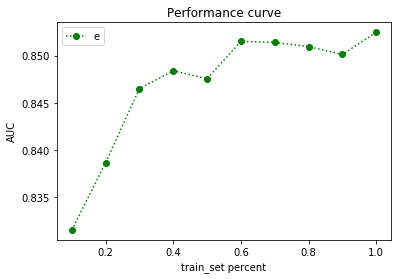

In [251]:
# Traçage de la courbe
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_percent, performance_ensemble, ':go')
plt.xlabel('train_set percent')
plt.ylabel('AUC')
plt.title('Performance curve')
plt.legend("ensemble")
plt.show()

### Modèle Deepnet

In [253]:
dataset_deepnet = []
deepnet = []

# Création des 10 modèles
for split in range(len(split_list)):
    dataset_deepnet.append(split_list[split]) # possibilité d'append directement les splits sans passer par dataset
    deepnet.append(api.create_deepnet(dataset_deepnet,{"name": "deepnet_"+(str(split+1)),
     "objective_field": "SeriousDlqin2yrs"}))
    api.ok(deepnet[split])
    

In [254]:
# Evaluation des modèles sur le validation_set
evaluation_deepnet = []

for model_number in range(len(deepnet)):
    evaluation_deepnet.append(api.create_evaluation(deepnet[model_number], 'dataset/5dacd5617811dd7f2d003bf5'))
    api.ok(evaluation_deepnet[model_number])

In [257]:
# Récupération des AUC
auc_deepnet = []
for eval_number in range(len(evaluation_deepnet)):
    auc_deepnet.append(evaluation_deepnet[eval_number]['object']['result']['model']['per_class_statistics'][1]['area_under_roc_curve'])
performance_deepnet = auc_deepnet   

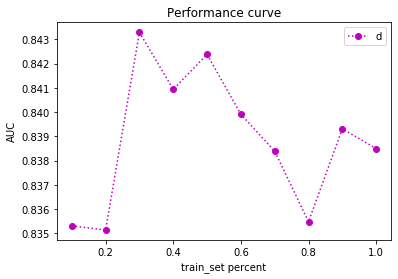

In [259]:
# Traçage de la courbe
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_percent, performance_deepnet, ':mo')
plt.xlabel('train_set percent')
plt.ylabel('AUC')
plt.title('Performance curve')
plt.legend("deepnet")
plt.show()

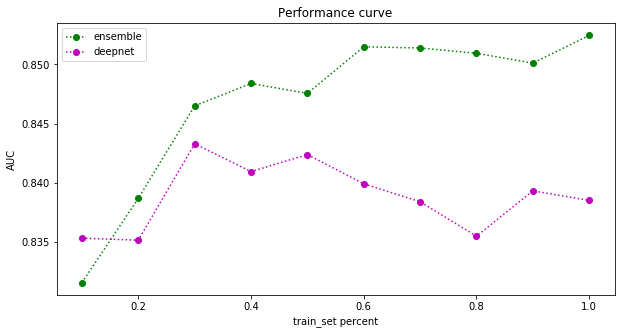

In [272]:
# Traçage de la courbe combinée
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(train_percent, performance_ensemble, ':go', train_percent, performance_deepnet, ':mo')
plt.xlabel('train_set percent')
plt.ylabel('AUC')
plt.title('Performance curve')
plt.legend(['ensemble', 'deepnet'])
plt.show()

In [273]:
train_sets = []
train_sets.append(api.get_dataset('dataset/5dbc37ed5299631c8200e5ac'))
train_sets.append(api.get_dataset('dataset/5dbc37eee47684746800eefd'))
train_sets.append(api.get_dataset('dataset/5dbc381de47684746800ef03'))
train_sets.append(api.get_dataset('dataset/5dbc381e7811dd7f2d00dcbd'))
train_sets.append(api.get_dataset('dataset/5dbc381f5299631c8200e5b8'))
train_sets.append(api.get_dataset('dataset/5dbc3820e47684746800ef06'))
train_sets.append(api.get_dataset('dataset/5dbc38217811dd7f2d00dcc0'))
train_sets.append(api.get_dataset('dataset/5dbc38225299631c8200e5bb'))
train_sets.append(api.get_dataset('dataset/5dbc3823e47684746800ef09'))
train_sets.append(api.get_dataset('dataset/5dbc38247811dd7f2d00dcc3'))

In [ ]:
# Evaluation sur le train:
evaluation_ontrain = []

for model_number in range(len(ensemble)):
    evaluation_train.append(api.create_evaluation(ensemble[model_number], 'dataset/5dacd5617811dd7f2d003bf5'))
    api.ok(evaluation[model_number])



In [4]:
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl
